### Project Dissertation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from nltk.tokenize.treebank import TreebankWordDetokenizer

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import os
import re
import string
import unicodedata
import itertools

In [2]:
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n

In [3]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)

Python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.2.4


In [4]:
df = pd.read_csv("C:/Users/Chan Ken Lok/Documents/Dissertations/depression-detection/data/tweets_combined.csv")
# insert the file path for the csv dataset

In [5]:
pd.set_option('display.max_colwidth', 1)

In [6]:
df.head()
# examples of the dataset

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia,0
1,1,I get to spend New Year's home again alone and lonely. ???•,1
2,2,"Depressed and lonely /: Stuck in a deep, never ending hole :(",1
3,3,"If this is your response to someone saying they're dealing with , you're a terrible person.",0
4,4,Apparently you get a free pass just by mentioning Where was I on the free badge day??!!,0


In [7]:
df.target.value_counts()

0    2357
1    843 
Name: target, dtype: int64

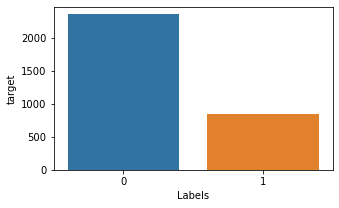

In [8]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [9]:
df.tweet.head(10), df.tweet.tail(10)

(0    Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia                              
 1    I get to spend New Year's home again alone and lonely. ???•                                                                                     
 2    Depressed and lonely /: Stuck in a deep, never ending hole :(                                                                                   
 3    If this is your response to someone saying they're dealing with , you're a terrible person.                                                     
 4    Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!                                                      
 5    When you will never again give birth to violent men..   pic.twitter.com/pkdPhhlUuZ                                                              
 6    Learning to pretend to have a good time had become a natural skill. I hope one day it is

In [10]:
# check non-depressive tweets
df[df["target"]==0].tweet.head()

0    Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
3    If this is your response to someone saying they're dealing with , you're a terrible person.                       
4    Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!                        
5    When you will never again give birth to violent men..   pic.twitter.com/pkdPhhlUuZ                                
7    Aw man im outta pizza rolls                                                                                       
Name: tweet, dtype: object

In [11]:
# check depressive tweets
df[df["target"]==1].tweet.head()

1     I get to spend New Year's home again alone and lonely. ???•                                     
2     Depressed and lonely /: Stuck in a deep, never ending hole :(                                   
6     Learning to pretend to have a good time had become a natural skill. I hope one day it is genuine
9     So far he stop texting me…after I said something…so hopefully he doesn't show up at my house…   
11    *sigh* ???? I haven't cried so much…I'm in so much pain…                                        
Name: tweet, dtype: object

### Pre process method 

In [12]:
df['tweet'] = df.tweet.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|█████████████████████████████████████████████████████████████████| 3200/3200 [00:00<00:00, 50392.62it/s]


In [13]:
df['tweet'].head(5)

0    Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
1    I get to spend New Year's home again alone and lonely. ???•                                                       
2    Depressed and lonely /: Stuck in a deep, never ending hole :(                                                     
3    If this is your response to someone saying they're dealing with , you're a terrible person.                       
4    Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!                        
Name: tweet, dtype: object

In [14]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
#contraction dictionary, could add more since the contraction module could not be import

In [15]:
#to replace the contraction in the texts
def get_contractions_dict(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = get_contractions_dict(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [16]:
##List of method to preprocess the words
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

In [17]:
def tweet_clean(words):
    words = re.sub(r"http\S+", "", words)# remove urls c
    words = re.sub(r'<([^>]*)>', ' ', words) # remove emojis c
    words = re.sub(r"pic\S+", "", words)# maybe remove pictures
    words = re.sub(r'@\w+', ' ', words) # remove at mentions c
    words = re.sub(r'#\w+', ' ', words) # remove hashtag symbol c
    words = replace_contractions(words) # no need change method c
    pattern = re.compile(r"[ \n\t]+") 
    words = pattern.sub(" ", words)      
    words = "".join("".join(s)[:2] for _, s in itertools.groupby(words))    # ???
    words = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', words) # remove all symbols and punctuation except for . , ! and ? might change the process
    return words.strip()

In [18]:
def preprocess(sample):
    # Tokenize
    words = word_tokenize(sample)

    # Normalize
    return normalize(words)

In [19]:
#preprocess the word
def tokenizer(s): 
    word = tweet_clean(s)
    return preprocess(word)

In [20]:
%%time
df['tweet'] = df['tweet'].apply(lambda x : tokenizer(x))
df['tweet'] = df['tweet'].apply(lambda x : TreebankWordDetokenizer().detokenize(x))
#tokenize to preprocessed and then detokenize to get word count

Wall time: 13.8 s


In [21]:
df['tweet'].head(3)
#example of the processed word

0    today selfcare beauty amp laugh kung fu panda three
1    get spend new year home alone lonely               
2    depress lonely stick deep never end hole           
Name: tweet, dtype: object

### Seperating into three types of data

In [22]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [23]:
# create train and validation set 
# 20% of the total is test, while the 80 would split to 80 train adn 20 validation 
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [24]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [25]:
train.shape, val.shape, test.shape

((2048, 3), (512, 3), (640, 3))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

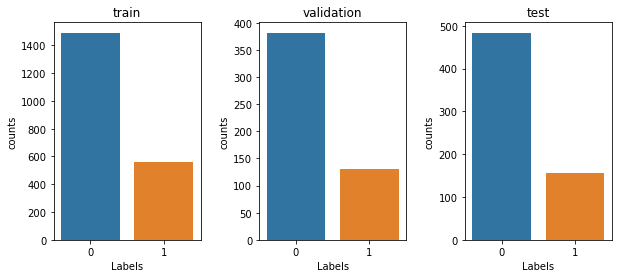

In [26]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [27]:
val.head(3)

,Unnamed: 0,tweet,target
0,1166,feel important,0
1,55,michael bed day barely functional car bad cold one katman,0
2,2321,ppl tweet lead cause depression reality pithy know show empathy stop,0


In [28]:
train.head(3)

,Unnamed: 0,tweet,target
0,3088,really wish would time draw blog sure would helpful many,0
1,948,cut ankle easier hide handle people find pretend care hurt,1
2,593,everything come back sudden good feel,1


For target that is 0

In [29]:
nondepressed_docs = [row['tweet'] for index,row in train.iterrows() if row['target'] == 0 ]
vec_0 = CountVectorizer()

In [30]:
X_0 = vec_0.fit_transform(nondepressed_docs)
tdm_0 = pd.DataFrame(X_0.toarray(), columns=vec_0.get_feature_names())

In [31]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))

In [32]:
probs_0 = []
for word,count in zip(word_list_0,count_list_0):
    probs_0.append(count/len(word_list_0))
res_0 = dict(zip(word_list_0,probs_0))

In [33]:
docs = [row['tweet'] for index,row in train.iterrows()]

vec = CountVectorizer()
X = vec.fit_transform(docs)

total_features = len(vec.get_feature_names())

In [34]:
total_cnts_features_0 = count_list_0.sum(axis=0)

### Method for making dict new to compare

In [35]:
def create_dict_test_0(word_list,freq,total_cnts_features):
    prob_s_with_ls = []
    for word in word_list:
        if word in freq.keys():
            count = freq[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features + total_features))
    return dict(zip(new_word_list,prob_s_with_ls))

For target is 1 

In [36]:
depressed_docs = [row['tweet'] for index,row in train.iterrows() if row['target'] == 1 ]
vec_1 = CountVectorizer()
X_1 = vec_1.fit_transform(depressed_docs)
tdm_1 = pd.DataFrame(X_1.toarray(), columns=vec_1.get_feature_names())
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))

In [37]:
probs_1 = []
for word,count in zip(word_list_1,count_list_1):
    probs_1.append(count/len(word_list_1))
res_1 = dict(zip(word_list_1,probs_1))

In [38]:
total_cnts_features_1 = count_list_1.sum(axis=0)
print(total_cnts_features_1)

4657


Setting up result with training data 

In [39]:
new_sentence = 'cut depress sad'
new_word_list = word_tokenize(new_sentence)

In [40]:
def show_new_dict(wordList, freq, total_cnts_features):
    prob_s_with_ls = []
    for word in wordList:
        if word in freq.keys():
            count = freq[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features + total_features))
    return dict(zip(wordList,prob_s_with_ls))

In [41]:
t = show_new_dict(new_word_list,freq_0,total_cnts_features_0)

In [42]:
t.values()

dict_values([0.00032168821977739175, 0.0012224152351540886, 0.0007077140835102619])

In [43]:
np.prod(list(t.values()))

2.7829906640161395e-10

In [44]:
def compare_values(a,b):
    if a > b :
        return 0
    elif b > a : 
        return 1

In [45]:
t = train[train['target'] == 0]
t.shape
train.shape[0]

2048

In [46]:
def predict_class(wordlist):
    t_0 = show_new_dict(wordlist,freq_0,total_cnts_features_0)
    t_1 = show_new_dict(wordlist,freq_1,total_cnts_features_1)
    
    t_0_val = np.prod(list(t_0.values()))
    t_1_val = np.prod(list(t_1.values()))
    
    t_0_shape = (train[train['target'] == 0]).shape[0]
    t_1_shape = (train[train['target'] == 1]).shape[0]
    t_all_shape = train.shape[0]
    
    prob_0 = t_0_val * (t_0_shape / t_all_shape)
    prob_1 = t_1_val * (t_1_shape / t_all_shape)
    
    return compare_values(prob_0,prob_1)

In [47]:
sample = val['tweet'].iloc[0]
print(predict_class(word_tokenize(sample)))

0


To validate the system

In [48]:
def predict_to_pd(file):
    temp_list = []
    for x in file['tweet']:
        result = predict_class(word_tokenize(x))
        temp_list.append(result)
    return temp_list    

In [49]:
##predict_to_pd(val)
target_val = [row['target'] for index,row in val.iterrows()]
##print(target_val)

### Checking the score

In [50]:
def accuracy_score_naive_bayes(predictList,actualList):
    i = 0
    for x in range(len(actualList)):
        if predictList[x] == actualList[x]:
            i = i + 1
        else:
            i
    score = i / len(actualList) 
    return 100*score

In [51]:
print(accuracy_score_naive_bayes(predict_to_pd(val),target_val))

68.9453125


In [52]:
def precision_score_0_naive_bayes(predictList,actualList):
    tp = 0
    fp = 0
    for x in range(len(actualList)):
        if (actualList[x] == 0) and (actualList[x] == predictList[x]):
            tp = tp + 1
        elif (actualList[x] == 1) and (predictList[x] == 0):
            fp = fp + 1
    score = tp / (tp+fp)
    return 100*score

def precision_score_1_naive_bayes(predictList,actualList):
    tp = 0
    fp = 0
    for x in range(len(actualList)):
        if (actualList[x] == 1) and (actualList[x] == predictList[x]):
            tp = tp + 1
        elif (actualList[x] == 0) and (predictList[x] == 1):
            fp = fp + 1
    score = tp / (tp+fp)
    return 100*score

def recall_score_0_naive_bayes(predictList,actualList):
    tp = 0
    fn = 0
    for x in range(len(actualList)):
        if (actualList[x] == 0) and (actualList[x] == predictList[x]):
            tp = tp + 1
        elif (actualList[x] == 0) and (predictList[x] == 1):
            fn = fn + 1
    score = tp / (tp+fn)
    return 100*score

def recall_score_1_naive_bayes(predictList,actualList):
    tp = 0
    fn = 0
    for x in range(len(actualList)):
        if (actualList[x] == 1) and (actualList[x] == predictList[x]):
            tp = tp + 1
        elif (actualList[x] == 1) and (predictList[x] == 0):
            fn = fn + 1
    score = tp / (tp+fn)
    return 100*score

def f_measure_naive_bayes(precision,recall):
    result = 2 * (precision * recall) / (precision + recall)
    return result

In [53]:
print("precision score of 0 :",precision_score_0_naive_bayes(predict_to_pd(val),target_val))
print("precision socre of 1 :",precision_score_1_naive_bayes(predict_to_pd(val),target_val))

print("recall score of 0 :",recall_score_0_naive_bayes(predict_to_pd(val),target_val))
print("recall socre of 1 :",recall_score_1_naive_bayes(predict_to_pd(val),target_val))

print("f measure 0 score:",f_measure_naive_bayes(precision_score_0_naive_bayes(predict_to_pd(val),target_val),recall_score_0_naive_bayes(predict_to_pd(val),target_val)))
print("f measure 1 score:",f_measure_naive_bayes(precision_score_0_naive_bayes(predict_to_pd(val),target_val),recall_score_1_naive_bayes(predict_to_pd(val),target_val)))

precision score of 0 : 81.23249299719888
precision socre of 1 : 40.64516129032258
recall score of 0 : 75.91623036649214
recall socre of 1 : 48.46153846153846
f measure 0 score: 78.48443843031122
f measure 1 score: 60.706750178598135


all the above is own method which could be taken into consideration when creating own method, however these are not valid and it could not be proven correct.

# Naive and SVM classifications

In [54]:
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [55]:
Encoder = LabelEncoder()

In [56]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(train['tweet'])

TfidfVectorizer(max_features=5000)

In [57]:
print(Tfidf_vect.vocabulary_)

{'really': 2866, 'wish': 3880, 'would': 3913, 'time': 3553, 'draw': 1059, 'blog': 421, 'sure': 3424, 'helpful': 1629, 'many': 2124, 'cut': 854, 'ankle': 170, 'easier': 1095, 'hide': 1640, 'handle': 1578, 'people': 2591, 'find': 1327, 'pretend': 2729, 'care': 558, 'hurt': 1713, 'everything': 1215, 'come': 704, 'back': 290, 'sudden': 3393, 'good': 1505, 'feel': 1307, 'ten': 3487, 'month': 2262, 'hiatus': 1639, 'watch': 3807, 'movie': 2286, 'multiplex': 2294, 'ugly': 3662, 'maybe': 2151, 'better': 378, 'matter': 2146, 'much': 2292, 'light': 2002, 'forest': 1375, 'end': 1158, 'get': 1467, 'lose': 2057, 'im': 1746, 'sad': 3023, 'empty': 1156, 'suicidal': 3403, 'admit': 83, 'moments': 2250, 'wonder': 3892, 'despite': 960, 'physically': 2632, 'unwell': 3703, 'past': 2571, 'week': 3830, 'mentally': 2191, 'strong': 3371, 'right': 2964, 'genuinely': 1463, 'excite': 1225, 'opportunity': 2503, 'kick': 1918, 'make': 2102, 'life': 1997, 'overcome': 2533, 'one': 2487, 'step': 3335, 'oh': 2471, 'crap'

In [58]:
Train_Y = Encoder.fit_transform(train['target'])
Test_Y = Encoder.fit_transform(val['target'])

In [59]:
Train_X_Tfidf = Tfidf_vect.transform(train['tweet'])
Test_X_Tfidf = Tfidf_vect.transform(val['tweet'])

In [60]:
print(Train_X_Tfidf)

  (0, 3913)	0.4720147376339591
  (0, 3880)	0.25147915953827904
  (0, 3553)	0.21271943154948933
  (0, 3424)	0.30593029390764775
  (0, 2866)	0.22778322813130666
  (0, 2124)	0.27365956997776786
  (0, 1629)	0.4101070626589089
  (0, 1059)	0.37426919214921633
  (0, 421)	0.37426919214921633
  (1, 2729)	0.33661480466416444
  (1, 2591)	0.21078530445943142
  (1, 1713)	0.27890300383321176
  (1, 1640)	0.34438361294834036
  (1, 1578)	0.3648180391496707
  (1, 1327)	0.2584685776318814
  (1, 1095)	0.34438361294834036
  (1, 854)	0.31863928057089186
  (1, 558)	0.28629145185087285
  (1, 170)	0.3793164952718026
  (2, 3393)	0.5907883948413533
  (2, 1505)	0.34815858594911986
  (2, 1307)	0.2716161547110807
  (2, 1215)	0.438045165102212
  (2, 704)	0.3583009952458822
  (2, 290)	0.3683967510538589
  :	:
  (2044, 2058)	0.4033670303180863
  (2044, 1984)	0.4419911428650134
  (2044, 1450)	0.3136846182552848
  (2044, 533)	0.4419911428650134
  (2044, 247)	0.4419911428650134
  (2045, 3770)	0.4090514613732597
  (2045, 

In [61]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes f1 measure Score -> ",f1_score(predictions_NB, Test_Y)*100)
print("Naive Bayes precision Score -> ",precision_score(predictions_NB, Test_Y)*100)
print("Naive Bayes recall Score -> ",recall_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  75.5859375
Naive Bayes f1 measure Score ->  10.071942446043165
Naive Bayes precision Score ->  5.384615384615385
Naive Bayes recall Score ->  77.77777777777779


In [62]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM f1 measure Score -> ",f1_score(predictions_SVM, Test_Y)*100)
print("SVM precision Score -> ",precision_score(predictions_SVM, Test_Y)*100)
print("SVM recall Score -> ",recall_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  78.125
SVM f1 measure Score ->  47.16981132075472
SVM precision Score ->  38.46153846153847
SVM recall Score ->  60.97560975609756


[Text(0, 0.5, 'scores'), Text(0.5, 0, 'Models'), Text(0.5, 1.0, 'F measures')]

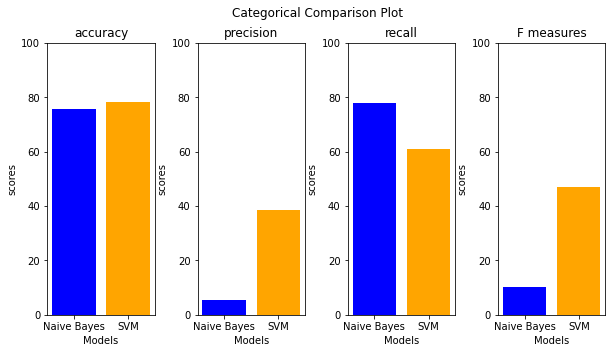

In [63]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

class_label = ['Naive Bayes', 'SVM']

plt.suptitle('Categorical Comparison Plot')
ax = fig.add_subplot(1,4,1)
plt.bar(class_label, [accuracy_score(predictions_NB, Test_Y)*100,accuracy_score(predictions_SVM, Test_Y)*100], color=['blue', 'orange'])
ax.set_ylim([0,100])
ax.set(xlabel='Models', ylabel="scores", title="accuracy")

ay = fig.add_subplot(1,4,2)
plt.bar(class_label, [precision_score(predictions_NB, Test_Y)*100,precision_score(predictions_SVM, Test_Y)*100], color=['blue', 'orange'])
ay.set_ylim([0,100])
ay.set(xlabel='Models', ylabel="scores", title="precision")

az = fig.add_subplot(1,4,3)
plt.bar(class_label, [recall_score(predictions_NB, Test_Y)*100,recall_score(predictions_SVM, Test_Y)*100], color=['blue', 'orange'])
az.set_ylim([0,100])
az.set(xlabel='Models', ylabel="scores", title="recall")

bx = fig.add_subplot(1,4,4)
plt.bar(class_label, [f1_score(predictions_NB, Test_Y)*100,f1_score(predictions_SVM, Test_Y)*100], color=['blue', 'orange'])
bx.set_ylim([0,100])
bx.set(xlabel='Models', ylabel="scores", title="F measures")

#### Test set and train set with naive and svm classifier

In [64]:
Test_X_Tfidf_f = Tfidf_vect.transform(test['tweet'])
Test_Y_f = Encoder.fit_transform(test['target'])

In [65]:
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf_f)

SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf_f)

[Text(0, 0.5, 'scores'), Text(0.5, 0, 'Models'), Text(0.5, 1.0, 'F measures')]

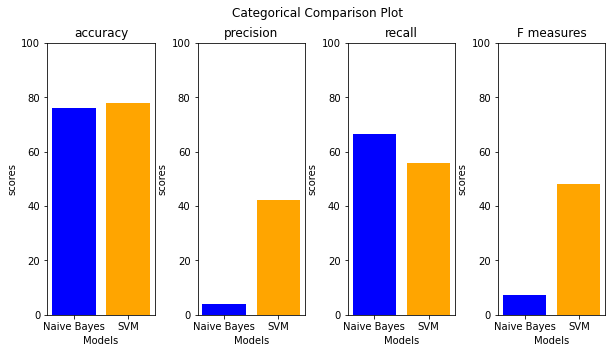

In [66]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

class_label = ['Naive Bayes', 'SVM']

plt.suptitle('Categorical Comparison Plot')
ax = fig.add_subplot(1,4,1)
plt.bar(class_label, [accuracy_score(predictions_NB, Test_Y_f)*100,accuracy_score(predictions_SVM, Test_Y_f)*100], color=['blue', 'orange'])
ax.set_ylim([0,100])
ax.set(xlabel='Models', ylabel="scores", title="accuracy")

ay = fig.add_subplot(1,4,2)
plt.bar(class_label, [precision_score(predictions_NB, Test_Y_f)*100,precision_score(predictions_SVM, Test_Y_f)*100], color=['blue', 'orange'])
ay.set_ylim([0,100])
ay.set(xlabel='Models', ylabel="scores", title="precision")

az = fig.add_subplot(1,4,3)
plt.bar(class_label, [recall_score(predictions_NB, Test_Y_f)*100,recall_score(predictions_SVM, Test_Y_f)*100], color=['blue', 'orange'])
az.set_ylim([0,100])
az.set(xlabel='Models', ylabel="scores", title="recall")

bx = fig.add_subplot(1,4,4)
plt.bar(class_label, [f1_score(predictions_NB, Test_Y_f)*100,f1_score(predictions_SVM, Test_Y_f)*100], color=['blue', 'orange'])
bx.set_ylim([0,100])
bx.set(xlabel='Models', ylabel="scores", title="F measures")

In [67]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y_f)*100)
print("Naive Bayes f1 measure Score -> ",f1_score(predictions_NB, Test_Y_f)*100)
print("Naive Bayes precision Score -> ",precision_score(predictions_NB, Test_Y_f)*100)
print("Naive Bayes recall Score -> ",recall_score(predictions_NB, Test_Y_f)*100)

Naive Bayes Accuracy Score ->  76.09375
Naive Bayes f1 measure Score ->  7.272727272727273
Naive Bayes precision Score ->  3.8461538461538463
Naive Bayes recall Score ->  66.66666666666666


In [68]:
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y_f)*100)
print("SVM f1 measure Score -> ",f1_score(predictions_SVM, Test_Y_f)*100)
print("SVM precision Score -> ",precision_score(predictions_SVM, Test_Y_f)*100)
print("SVM recall Score -> ",recall_score(predictions_SVM, Test_Y_f)*100)

SVM Accuracy Score ->  77.8125
SVM f1 measure Score ->  48.17518248175182
SVM precision Score ->  42.30769230769231
SVM recall Score ->  55.932203389830505
